   <html>
    <h1>Project: Computer Vision (IN412)</h1>
    <h2></h2>
    <p><strong>Name:</strong> Abdallah Soliman Alzoghby<br>
    <strong>Registration Number:</strong> 211003603</p>
   </html>



# Table of Contents
- [1. Import Libraries](#import-libraries)
- [2. Downloading Data](#downloading-data)
- [3. Extracting Files](#extracting-files)
- [4. Reading Video Information](#reading-video-information)
- [5. Displaying Sample Frames](#displaying-sample-frames)
- [6. Creating a Video from Images](#creating-a-video-from-images)
- [7. Loading Ground Truth Data](#loading-ground-truth-data)
- [8. Creating Masks](#creating-masks)
- [9. Training U-Net Model](#training-u-net-model)
- [10. Evaluating and Visualizing Results](#evaluating-and-visualizing-results)
- [11. Metrics Calculation](#metrics-calculation)
- [12. Training Mask R-CNN](#training-mask-r-cnn)
- [13. Saving and Evaluating Models](#saving-and-evaluating-models)

# <a name="import-libraries"></a>1. Import Libraries

In [ ]:
import os
import zipfile
import cv2
import configparser
import shutil
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Resize, Compose
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms.functional as F
from torchvision.models.detection import maskrcnn_resnet50_fpn
import torchvision.transforms.functional as TF

In [ ]:
!pip install SoccerNet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 63.8 MB/s eta 0:00:00


# <a name="downloading-data"></a>2. Downloading Data

In [ ]:
from SoccerNet.Downloader import SoccerNetDownloader
data_directory = "/content/SoccerNet"
mySoccerNetDownloader = SoccerNetDownloader(LocalDirectory=data_directory)
mySoccerNetDownloader.downloadDataTask(task="tracking", split=["train"])


# <a name="extracting-files"></a>3. Extracting Files

In [ ]:
zip_paths = {
    "train": "/content/SoccerNet/tracking/train.zip",

}
extract_paths = {
    "train": "/content/SoccerNet/tracking/train_data",

}
for split in zip_paths:
    zip_path = zip_paths[split]
    extract_path = extract_paths[split]
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Extraction of {split} data is done to {extract_path}")

Extraction of train data is done to /content/SoccerNet/tracking/train_data


# <a name="reading-video-information"></a>4. Reading Video Information

In [ ]:
seq_info_path = "/content/SoccerNet/tracking/train_data/train/SNMOT-065/seqinfo.ini"
config = configparser.ConfigParser()
config.read(seq_info_path)
img_width = int(config['Sequence']['imWidth'])
img_height = int(config['Sequence']['imHeight'])
frame_rate = int(config['Sequence']['frameRate'])
print(f"Image Width: {img_width}, Image Height: {img_height}, Frame Rate: {frame_rate}")

Image Width: 1920, Image Height: 1080, Frame Rate: 25


# <a name="displaying-sample-frames"></a>5. Displaying Sample Frames

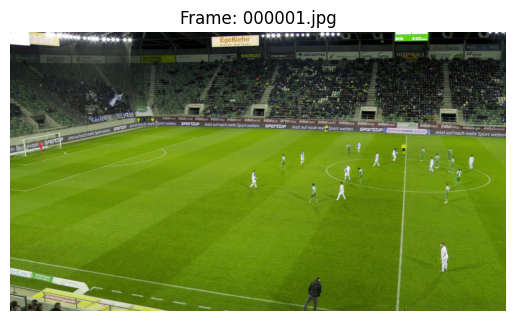

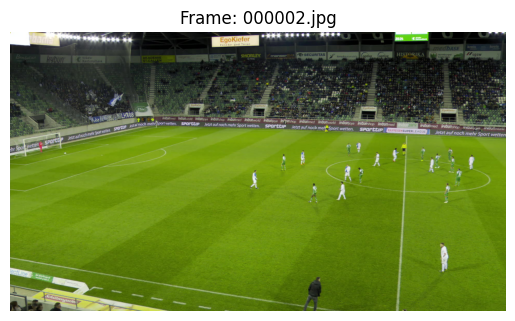

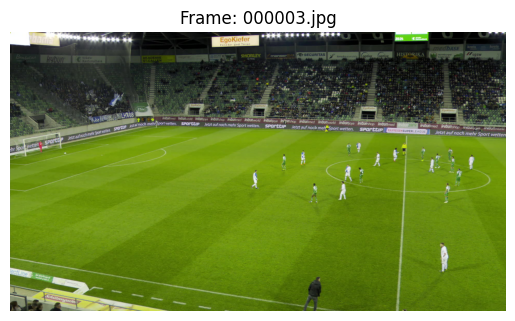

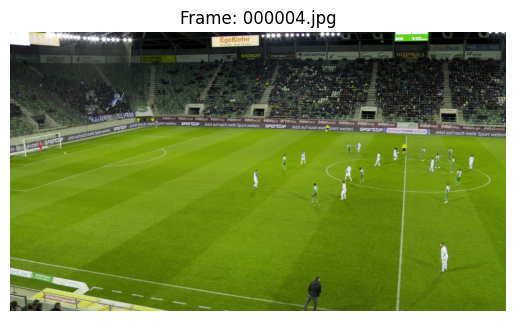

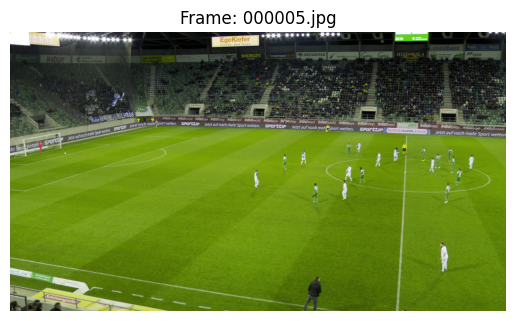

In [ ]:
img_folder_path = "/content/SoccerNet/tracking/train_data/train/SNMOT-065/img1"
images = sorted(os.listdir(img_folder_path))[:5]
for img_name in images:
    img_path = os.path.join(img_folder_path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Frame: {img_name}")
    plt.axis('off')
    plt.show()

#  Displaying Sample Frames

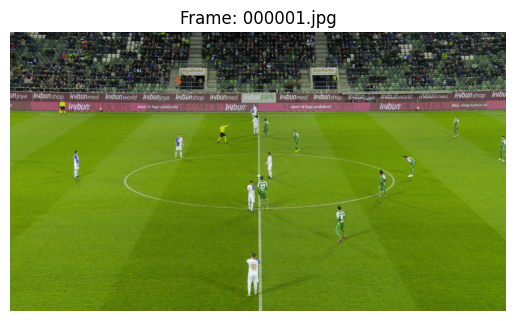

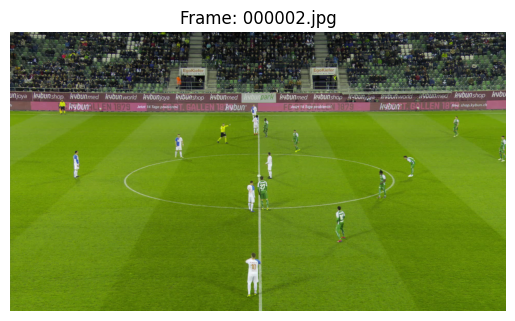

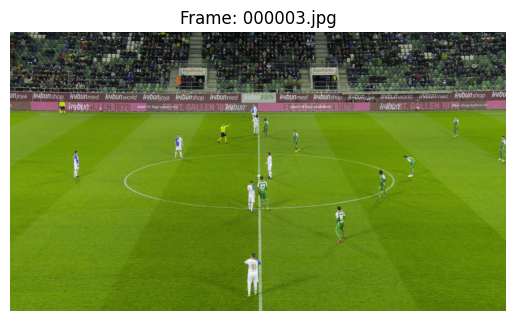

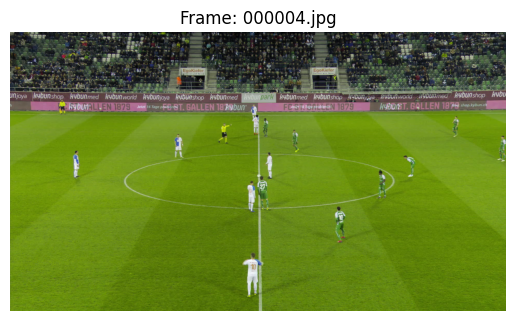

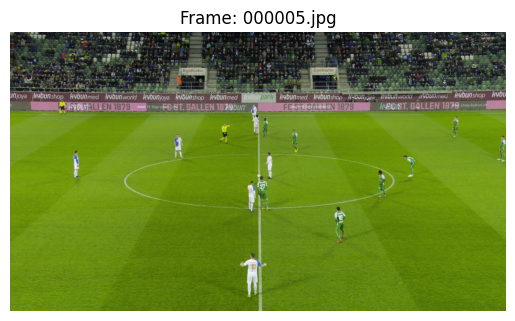

In [ ]:
"""
This cell loads and displays the first 5 frames from the 'img1' folder
of the training data to ensure the images are correctly loaded.
"""
img_folder_path = os.path.join(extract_paths["train"], "train", "SNMOT-060", "img1")
images = sorted(os.listdir(img_folder_path))[:5]
for img_name in images:
    img_path = os.path.join(img_folder_path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Frame: {img_name}")
    plt.axis('off')
    plt.show()

# <a name="creating-a-video-from-images"></a>6. Creating a Video from Images

In [ ]:
def create_video_from_images(img_folder_path, output_video_path, frame_rate):
    images = sorted([img for img in os.listdir(img_folder_path) if img.endswith(".jpg")])
    if len(images) == 0:
        print("No images found in the folder.")
        return
    first_image_path = os.path.join(img_folder_path, images[0])
    frame = cv2.imread(first_image_path)
    height, width, _ = frame.shape
    out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), frame_rate, (width, height))
    for img_name in images:
        img_path = os.path.join(img_folder_path, img_name)
        frame = cv2.imread(img_path)
        out.write(frame)
    out.release()
    print(f"Video created at {output_video_path}")
create_video_from_images(
    "/content/SoccerNet/tracking/train_data/train/SNMOT-065/img1",
    "/content/SoccerNet/frame_video.mp4",
    25
)

Video created at /content/SoccerNet/frame_video.mp4


# <a name="loading-ground-truth-data"></a>7. Loading Ground Truth Data

In [ ]:
def load_ground_truth(gt_file):
    gt_data = pd.read_csv(gt_file, header=None)
    gt_data.columns = ['frame', 'id', 'x', 'y', 'width', 'height', 'score', 'class', 'visibility', 'extra_column']
    gt_data = gt_data.iloc[:, :9]
    ground_truth = {}
    for frame_number in gt_data['frame'].unique():
        frame_data = gt_data[gt_data['frame'] == frame_number]
        frame_truth = []
        for _, row in frame_data.iterrows():
            frame_truth.append((row['class'], row['x'], row['y'], row['width'], row['height']))
        ground_truth[frame_number] = frame_truth
    return ground_truth
gt_file = "/content/SoccerNet/tracking/train_data/train/SNMOT-065/gt/gt.txt"
ground_truth = load_ground_truth(gt_file)
print(f"Loaded ground truth for {len(ground_truth)} frames.")
print("Ground Truth Example:")
for frame, objects in list(ground_truth.items())[:5]:
    print(f"Frame {frame}: {objects}")

Loaded ground truth for 750 frames.
Ground Truth Example:
Frame 1: [(-1, 1662, 814, 38, 119), (-1, 1774, 474, 24, 58), (-1, 1617, 484, 23, 60), (-1, 1477, 448, 29, 53), (-1, 1403, 464, 28, 57), (-1, 1339, 422, 19, 45), (-1, 1256, 578, 43, 75), (-1, 1292, 509, 29, 70), (-1, 928, 535, 33, 72), (-1, 1125, 458, 15, 56), (-1, 1681, 584, 23, 77), (-1, 1717, 527, 30, 70), (-1, 1696, 481, 25, 63), (-1, 1644, 470, 23, 56), (-1, 1693, 449, 20, 53), (-1, 1588, 445, 15, 54), (-1, 1345, 522, 24, 63), (-1, 1155, 583, 41, 78), (-1, 1301, 426, 18, 52), (-1, 1046, 470, 24, 64), (-1, 110, 419, 22, 48), (-1, 1512, 428, 21, 49), (-1, 1218, 357, 14, 31), (-1, 210, 466, 7, 5)]
Frame 2: [(-1, 1662, 813, 38, 119), (-1, 1774, 474, 24, 58), (-1, 1618, 485, 22, 60), (-1, 1478, 448, 29, 53), (-1, 1405, 464, 27, 57), (-1, 1339, 423, 19, 44), (-1, 1259, 578, 43, 74), (-1, 1294, 510, 28, 70), (-1, 930, 535, 33, 72), (-1, 1126, 458, 16, 56), (-1, 1681, 584, 23, 77), (-1, 1718, 527, 30, 70), (-1, 1696, 481, 25, 63), (

# Loading ground_truth



In [ ]:
gt_file = "/content/SoccerNet/tracking/train_data/train/SNMOT-065/gt/gt.txt"
gt_data = pd.read_csv(gt_file, header=None)
gt_data.columns = ['frame', 'id', 'x', 'y', 'width', 'height', 'score', 'class', 'visibility', 'extra_column']
ground_truth = gt_data['class'].tolist()
print(f"Ground Truth: {ground_truth[:10]}")

Ground Truth: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


# <a name="creating-masks"></a>8. Creating Masks

In [ ]:
gt_file_path = os.path.join(extract_paths["train"], "train", "SNMOT-060", "gt", "gt.txt")
gt_data = pd.read_csv(gt_file_path, header=None)
gt_data.columns = ['frame', 'id', 'x', 'y', 'width', 'height', 'score', 'class', 'visibility', 'extra_column']

def create_masks(gt_data, img_folder_path, mask_output_path):
    os.makedirs(mask_output_path, exist_ok=True)
    for frame_number in gt_data['frame'].unique():
        frame_data = gt_data[gt_data['frame'] == frame_number]
        first_image_path = os.path.join(img_folder_path, f"{frame_number:06d}.jpg")
        if not os.path.exists(first_image_path):
            continue
        frame = cv2.imread(first_image_path)
        mask = np.zeros((frame.shape[0], frame.shape[1]), dtype=np.uint8)
        for _, row in frame_data.iterrows():
            x, y, w, h = int(row['x']), int(row['y']), int(row['width']), int(row['height'])
            mask[y:y+h, x:x+w] = int(row['class'])
        mask_path = os.path.join(mask_output_path, f"{frame_number:06d}.png")
        Image.fromarray(mask).save(mask_path)
        print(f"Mask created for frame {frame_number} at {mask_path}")

mask_output_path = os.path.join(extract_paths["train"], "train", "SNMOT-060", "masks")
create_masks(gt_data, img_folder_path, mask_output_path)


<ipython-input-70-02622953fa15>:16: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  mask[y:y+h, x:x+w] = int(row['class'])


Mask created for frame 1 at /content/SoccerNet/tracking/train_data/train/SNMOT-060/masks/000001.png
Mask created for frame 2 at /content/SoccerNet/tracking/train_data/train/SNMOT-060/masks/000002.png
Mask created for frame 3 at /content/SoccerNet/tracking/train_data/train/SNMOT-060/masks/000003.png
Mask created for frame 4 at /content/SoccerNet/tracking/train_data/train/SNMOT-060/masks/000004.png
Mask created for frame 5 at /content/SoccerNet/tracking/train_data/train/SNMOT-060/masks/000005.png
Mask created for frame 6 at /content/SoccerNet/tracking/train_data/train/SNMOT-060/masks/000006.png
Mask created for frame 7 at /content/SoccerNet/tracking/train_data/train/SNMOT-060/masks/000007.png
Mask created for frame 8 at /content/SoccerNet/tracking/train_data/train/SNMOT-060/masks/000008.png
Mask created for frame 9 at /content/SoccerNet/tracking/train_data/train/SNMOT-060/masks/000009.png
Mask created for frame 10 at /content/SoccerNet/tracking/train_data/train/SNMOT-060/masks/000010.png

# Placeholder for Model Training

# <a name="training-u-net-model"></a>9.  U-Net Implementation

In [ ]:
class SoccerDataset(Dataset):
    def __init__(self, img_folder, mask_folder, transform=None):
        self.img_folder = img_folder
        self.mask_folder = mask_folder
        self.images = sorted(os.listdir(img_folder))
        self.masks = sorted(os.listdir(mask_folder))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_folder, self.images[idx])
        mask_path = os.path.join(self.mask_folder, self.masks[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, torch.tensor(np.array(mask), dtype=torch.long)

# Define dataset and DataLoader
img_folder = os.path.join(extract_paths["train"], "train", "SNMOT-060", "img1")
mask_folder = os.path.join(extract_paths["train"], "train", "SNMOT-060", "masks")

transform = Compose([
    Resize((256, 256)),
    ToTensor(),
])

dataset = SoccerDataset(img_folder, mask_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Test the DataLoader
for images, masks in dataloader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of masks shape: {masks.shape}")
    break


Batch of images shape: torch.Size([4, 3, 256, 256])
Batch of masks shape: torch.Size([4, 1, 256, 256])


# Defining U-Net Model

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool = nn.MaxPool2d(2, 2)
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.pool(x)
        x = self.decoder(x)
        return x

# Instantiate the model
model = UNet(in_channels=3, out_channels=2)  # 2 classes (background and object)
print(model)


UNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (decoder): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 2, kernel_size=(1, 1), stride=(1, 1))
  )
)


# U-Net Training and Evaluation

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Training loop
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        # Ensure masks are in the correct format and resize them
        if len(masks.shape) == 3:  # Shape: [Batch, Height, Width]
            masks = masks.unsqueeze(1).float()  # Shape: [Batch, Channels=1, Height, Width]
        # Change data type to float before interpolation
        masks = masks.float()
        # Use torch.nn.functional.interpolate instead of torchvision.transforms.functional
        masks = torch.nn.functional.interpolate(masks, size=(128, 128), mode='nearest')   # Resize masks
        masks = masks.squeeze(1).long()  # Remove channel dimension and convert back to long

        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, masks)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model weights
        epoch_loss += loss.item()  # Accumulate epoch loss

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/5], Loss: 21.3843
Epoch [2/5], Loss: 11.4428
Epoch [3/5], Loss: 7.7234
Epoch [4/5], Loss: 6.6387
Epoch [5/5], Loss: 6.1363


# <a name="evaluating-and-visualizing-results"></a>10. Evaluating and Visualizing Results


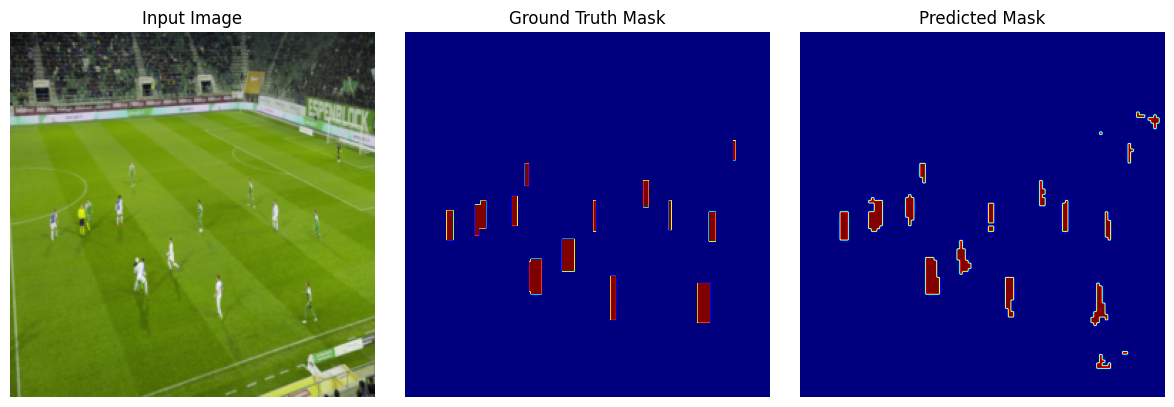

In [ ]:
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        # Get model predictions
        outputs = model(images)
        outputs = torch.argmax(outputs, dim=1).cpu().numpy()  # Convert predictions to class indices

        # Display the first image, ground truth mask, and predicted mask
        plt.figure(figsize=(12, 4))

        # Input Image
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(images[0].cpu().permute(1, 2, 0))  # Convert from CHW to HWC format
        plt.axis("off")

        # Ground Truth Mask
        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        mask = masks[0].cpu().squeeze().numpy()  # Ensure compatible format
        plt.imshow(mask, cmap="jet")
        plt.axis("off")

        # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(outputs[0], cmap="jet")  # Use colormap for better visualization
        plt.axis("off")

        plt.tight_layout()
        plt.show()
        break


# <a name="metrics-calculation"></a>11. Metrics Calculation

#iou and Pixel-wise Accuracy

In [ ]:
def calculate_iou(pred_mask, true_mask, num_classes):
    ious = []
    for cls in range(num_classes):
        pred_cls = (pred_mask == cls)
        true_cls = (true_mask == cls)
        intersection = (pred_cls & true_cls).sum()
        union = (pred_cls | true_cls).sum()
        if union == 0:
            ious.append(1.0)  # Perfect match if no pixels for this class
        else:
            ious.append(intersection / union)
    return np.mean(ious)

# Evaluate U-Net
model.eval()
with torch.no_grad():
    iou_scores = []
    pixel_accuracies = []
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        outputs = torch.argmax(outputs, dim=1).cpu().numpy()

        for i in range(len(outputs)):
            # Resize true_mask to match pred_mask dimensions
            true_mask = masks[i].cpu().squeeze()  # Remove channel dimension
            true_mask = torch.nn.functional.interpolate(true_mask.unsqueeze(0).unsqueeze(0).float(),
                                                        size=(128, 128),
                                                        mode='nearest').squeeze().long().numpy()

            # Calculate IoU and Pixel Accuracy
            iou = calculate_iou(outputs[i], true_mask, num_classes=2)  # Adjust num_classes as needed
            iou_scores.append(iou)

    print(f"Mean IoU: {np.mean(iou_scores):.4f}")


Mean IoU: 0.7885


In [ ]:
def calculate_pixel_accuracy(pred_mask, true_mask):
    correct = (pred_mask == true_mask).sum()
    total = true_mask.size
    return correct / total

# Evaluate Pixel-wise Accuracy
model.eval()
with torch.no_grad():
    pixel_accuracies = []
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        outputs = torch.argmax(outputs, dim=1).cpu().numpy()

        for i in range(len(outputs)):
            # Resize true_mask to match pred_mask dimensions
            true_mask = masks[i].cpu().squeeze()  # Remove channel dimension
            true_mask = torch.nn.functional.interpolate(true_mask.unsqueeze(0).unsqueeze(0).float(),
                                                        size=(128, 128),
                                                        mode='nearest').squeeze().long().numpy()

            # Calculate Pixel Accuracy
            pixel_acc = calculate_pixel_accuracy(outputs[i], true_mask)
            pixel_accuracies.append(pixel_acc)

    print(f"Mean Pixel-wise Accuracy: {np.mean(pixel_accuracies):.4f}")

Mean Pixel-wise Accuracy: 0.9885


# video

In [ ]:
frame_height, frame_width = 256, 768  # Adjust dimensions as needed
output_video_path = "segmentation_results.mp4"
frame_rate = 10  # Lower frame rate for a slower video
video_writer = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), frame_rate, (frame_width, frame_height))

model.eval()
with torch.no_grad():
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        outputs = torch.argmax(outputs, dim=1).cpu().numpy()

        for i in range(images.shape[0]):  # Loop through batch
            # Convert tensors to NumPy arrays
            input_image = images[i].cpu().permute(1, 2, 0).numpy()
            ground_truth = masks[i].cpu().squeeze().numpy()
            prediction = outputs[i]

            # Normalize input image
            input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min()) * 255
            input_image = input_image.astype(np.uint8)

            # Apply color maps
            gt_colored = cv2.applyColorMap((ground_truth * 255).astype(np.uint8), cv2.COLORMAP_JET)
            pred_colored = cv2.applyColorMap((prediction * 255).astype(np.uint8), cv2.COLORMAP_JET)

            # Resize predicted mask
            pred_colored = cv2.resize(pred_colored, (input_image.shape[1], input_image.shape[0]), interpolation=cv2.INTER_NEAREST)

            # Stack the images horizontally
            combined_frame = np.hstack((
                cv2.cvtColor(input_image, cv2.COLOR_RGB2BGR),
                gt_colored,
                pred_colored
            ))

            # Ensure frame dimensions match video writer setup
            combined_frame = cv2.resize(combined_frame, (frame_width, frame_height))

            # Repeat each frame to make the video slower
            repeat_frames = 5  # Number of times to repeat each frame
            for _ in range(repeat_frames):
                video_writer.write(combined_frame)

        break  # Remove this to process the entire dataset

# Release the video writer
video_writer.release()
print(f"Video saved at {output_video_path}")


Video saved at segmentation_results.mp4


# save model

In [ ]:
torch.save(model.state_dict(), "unet_model.pth")
print("Model saved successfully.")


Model saved successfully.


# recall , precsion & F1-Score:U-NET

In [ ]:
def calculate_metrics_per_batch(pred_mask, true_mask, num_classes=2):
    """
    Calculate Precision, Recall, and F1-Score for each batch.
    """
    # Resize true_mask to match pred_mask dimensions using OpenCV
    true_mask = cv2.resize(true_mask, (pred_mask.shape[1], pred_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    batch_metrics = {'precision': [], 'recall': [], 'f1_score': []}

    for cls in range(num_classes):
        pred_cls = (pred_mask == cls)
        true_cls = (true_mask == cls)

        TP = (pred_cls & true_cls).sum()  # True Positives
        FP = (pred_cls & ~true_cls).sum()  # False Positives
        FN = (~pred_cls & true_cls).sum()  # False Negatives

        # Calculate Precision
        precision = TP / (TP + FP + 1e-6)  # Avoid division by zero
        # Calculate Recall
        recall = TP / (TP + FN + 1e-6)
        # Calculate F1-Score
        f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)

        batch_metrics['precision'].append(precision)
        batch_metrics['recall'].append(recall)
        batch_metrics['f1_score'].append(f1_score)

    return batch_metrics

# U-Net evaluation for each batch
model.eval()

with torch.no_grad():
    for batch_idx, (images, masks) in enumerate(dataloader):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        outputs = torch.argmax(outputs, dim=1).cpu().numpy()  # Get predicted class masks

        for i in range(len(outputs)):  # Calculate metrics for each image in the batch
            true_mask = masks[i].cpu().squeeze().numpy()  # Ground truth mask
            pred_mask = outputs[i]  # Predicted mask

            # Calculate metrics for each class
            frame_metrics = calculate_metrics_per_batch(pred_mask, true_mask, num_classes=2)

            # Print the metrics for each image
            print(f"Batch {batch_idx + 1}, Image {i + 1}")
            print(f"  Precision per Class: {frame_metrics['precision']}")
            print(f"  Recall per Class: {frame_metrics['recall']}")
            print(f"  F1-Score per Class: {frame_metrics['f1_score']}")
            print("-" * 40)


Batch 1, Image 1
  Precision per Class: [0.9945004015946054, 0.8009950208905721]
  Recall per Class: [0.9975207635429825, 0.643999997424]
  F1-Score per Class: [0.9960077927887255, 0.7139684606077136]
----------------------------------------
Batch 1, Image 2
  Precision per Class: [0.9869170578411945, 0.8141809271046921]
  Recall per Class: [0.9952026258682488, 0.6143911427778761]
  F1-Score per Class: [0.9910420243833147, 0.7003149657201954]
----------------------------------------
Batch 1, Image 3
  Precision per Class: [0.9879964805814482, 0.7224576255880135]
  Recall per Class: [0.9917360584789467, 0.6409774424041778]
  F1-Score per Class: [0.9898622376301778, 0.6792823689587947]
----------------------------------------
Batch 1, Image 4
  Precision per Class: [0.9953712390695333, 0.6926952123609692]
  Recall per Class: [0.9923916432184352, 0.7879656137880642]
  F1-Score per Class: [0.9938787079837696, 0.7372649156433726]
----------------------------------------
Batch 2, Image 1
  P

# Mask R-CNN

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import ToTensor, Resize, Compose
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt


# <a name="training-mask-r-cnn"></a>12. Training Mask R-CNN



# Define Dataset for Mask R-CNN

In [ ]:
class SoccerDatasetForMaskRCNN(Dataset):
    def __init__(self, img_folder, mask_folder, transform=None):
        self.img_folder = img_folder
        self.mask_folder = mask_folder
        self.images = sorted(os.listdir(img_folder))
        self.masks = sorted(os.listdir(mask_folder))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_folder, self.images[idx])
        mask_path = os.path.join(self.mask_folder, self.masks[idx])

        # Load image and mask
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        # Convert mask to numpy array
        mask = np.array(mask)

        # Extract unique classes (excluding background 0)
        obj_ids = np.unique(mask)[1:]

        # Create bounding boxes and masks for each class
        boxes = []
        masks = []
        for obj_id in obj_ids:
            obj_mask = (mask == obj_id).astype(np.uint8)
            masks.append(obj_mask)
            pos = np.where(obj_mask)
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        labels = torch.ones((len(obj_ids),), dtype=torch.int64)  # All objects have label 1

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks
        }

        if self.transform:
            image = self.transform(image)

        return image, target


# Load Data

In [ ]:

img_folder = "/content/SoccerNet/tracking/train_data/train/SNMOT-060/img1"
mask_folder = "/content/SoccerNet/tracking/train_data/train/SNMOT-060/masks"

transform = Compose([
    Resize((256, 256)),
    ToTensor(),
])

dataset = SoccerDatasetForMaskRCNN(img_folder, mask_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))



#  download Mask R-CNN

In [ ]:
model = maskrcnn_resnet50_fpn(pretrained=True)
num_classes = 2  # Background + 1 object class
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:02<00:00, 77.9MB/s]


# Train RCNN:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
num_epochs = 1

In [ ]:
# Step 6: Train Mask R-CNN with Debugging
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    print(f"Starting Epoch {epoch+1}/{num_epochs}...")

    # Checking data validity (First Batch Only for Debugging)
    for batch_idx, (images, targets) in enumerate(dataloader):
        print(f"Batch {batch_idx}: Checking data...")

        for target_idx, target in enumerate(targets):
            print(f"Target {target_idx}:")
            print(f"  Boxes: {target['boxes']}")
            print(f"  Labels: {target['labels']}")
            print(f"  Masks Shape: {target['masks'].shape}")

            # Check for invalid boxes
            if (target["boxes"][:, 2] <= target["boxes"][:, 0]).any() or (target["boxes"][:, 3] <= target["boxes"][:, 1]).any():
                print(f"Invalid boxes detected in Batch {batch_idx}, Target {target_idx}")

            # Check for NaN or Inf
            if torch.isnan(target["boxes"]).any() or torch.isinf(target["boxes"]).any():
                print(f"NaN or Inf detected in boxes of Batch {batch_idx}, Target {target_idx}")

            # Check for invalid labels
            if (target["labels"] < 1).any():
                print(f"Invalid labels detected in Batch {batch_idx}, Target {target_idx}")
        break  # Only check the first batch for debugging

    # Main Training Loop
    for batch_idx, (images, targets) in enumerate(dataloader):
        print(f"Batch {batch_idx}: Processing...")

        # Move data to device
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Filter valid data
        valid_indices = []
        for idx, target in enumerate(targets):
            boxes = target["boxes"]

            # Check for invalid boxes
            if (boxes[:, 2] <= boxes[:, 0]).any() or (boxes[:, 3] <= boxes[:, 1]).any():
                print(f"Invalid boxes detected in Batch {batch_idx}, Target {idx}: {boxes}")
                continue

            # Check for NaN or infinite values
            if torch.isnan(boxes).any() or torch.isinf(boxes).any():
                print(f"NaN or Inf detected in Batch {batch_idx}, Target {idx}: {boxes}")
                continue

            valid_indices.append(idx)

        # Filter out invalid data
        images = [images[i] for i in valid_indices]
        targets = [targets[i] for i in valid_indices]

        if len(images) == 0:
            print(f"No valid data in Batch {batch_idx}. Skipping...")
            continue

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        losses = model(images, targets)

        # Debug individual loss components
        print("Loss components:")
        for loss_name, loss_value in losses.items():
            print(f"  {loss_name}: {loss_value.item() if not torch.isnan(loss_value) else 'NaN'}")

        # Compute total loss
        loss = sum(loss for loss in losses.values())
        if torch.isnan(loss):
            print("NaN detected in total loss. Skipping this batch.")
            continue

        # Backward pass and optimizer step
        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)

        optimizer.step()

        # Accumulate epoch loss
        epoch_loss += loss.item()

        # Print progress every 10 batches
        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(dataloader)}], Loss: {loss.item():.4f}")

    print(f"Epoch [{epoch+1}/{num_epochs}] Completed. Total Loss: {epoch_loss:.4f}")


Starting Epoch 1/1...


<ipython-input-26-dfb7c0624f4b>:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)


Batch 0: Checking data...
Target 0:
  Boxes: tensor([[ 199.,  243., 1750., 1044.]])
  Labels: tensor([1])
  Masks Shape: torch.Size([1, 1080, 1920])
Target 1:
  Boxes: tensor([[  17.,  250., 1548.,  910.]])
  Labels: tensor([1])
  Masks Shape: torch.Size([1, 1080, 1920])
Batch 0: Processing...
Loss components:
  loss_classifier: 0.895201563835144
  loss_box_reg: 1.0657481652742717e-05
  loss_mask: 0.5481255054473877
  loss_objectness: 0.14401769638061523
  loss_rpn_box_reg: 0.13796786963939667
Epoch [1/1], Batch [0/375], Loss: 1.7253
Batch 1: Processing...
Loss components:
  loss_classifier: 0.7509965300559998
  loss_box_reg: 1.1045965948142111e-05
  loss_mask: 0.5387044548988342
  loss_objectness: 0.2267775535583496
  loss_rpn_box_reg: 0.31430521607398987
Batch 2: Processing...
Loss components:
  loss_classifier: 0.5408318042755127
  loss_box_reg: 1.063292074832134e-05
  loss_mask: 0.5237337350845337
  loss_objectness: 0.14231060445308685
  loss_rpn_box_reg: 0.20904479920864105
Batch 

# <a name="saving-and-evaluating-models"></a>13. Saving and Evaluating Models

In [ ]:

torch.save(model.state_dict(), "mask_rcnn_model.pth")
print("Model saved successfully.")


Model saved successfully.


# Evaluation

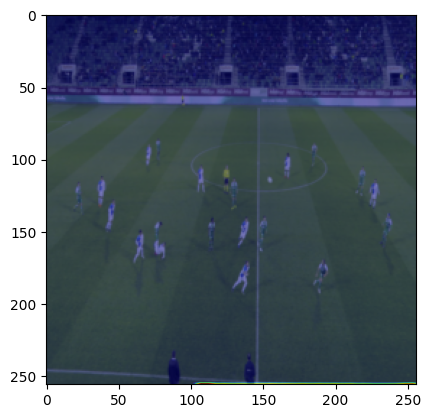

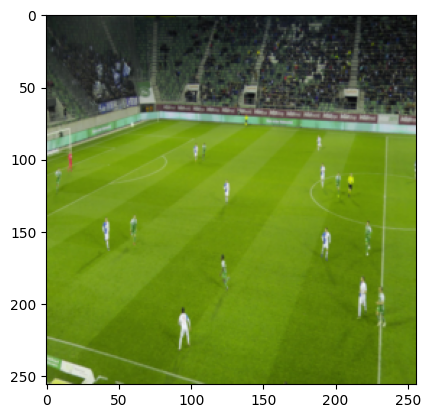

In [ ]:
model.eval()
with torch.no_grad():
    for images, targets in dataloader:
        images = [image.to(device) for image in images]
        outputs = model(images)

        for i, output in enumerate(outputs):
            image = images[i].cpu().permute(1, 2, 0).numpy()
            masks = output["masks"].cpu().numpy()
            boxes = output["boxes"].cpu().numpy()

            plt.imshow(image)
            for mask, box in zip(masks, boxes):
                plt.imshow(mask[0], alpha=0.5, cmap="jet")
                plt.gca().add_patch(
                    plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                  fill=False, edgecolor="red", linewidth=2)
                )
            plt.show()
        break


# IOU and Pixel-wise Accuracy

In [ ]:
import numpy as np
import torch

def calculate_iou(pred_mask, true_mask, num_classes):

    ious = []
    for cls in range(num_classes):
        pred_cls = (pred_mask == cls)
        true_cls = (true_mask == cls)
        intersection = (pred_cls & true_cls).sum()
        union = (pred_cls | true_cls).sum()
        if union == 0:
            ious.append(1.0)
        else:
            ious.append(intersection / union)
        print(f"Class {cls}: IoU = {ious[-1]:.4f}")
    mean_iou = np.mean(ious)
    print(f"Mean IoU: {mean_iou:.4f}")
    return mean_iou
model.eval()
iou_scores = []

with torch.no_grad():
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        outputs = torch.argmax(outputs, dim=1).cpu().numpy()

        for i in range(len(outputs)):
            true_mask = masks[i].cpu().squeeze().numpy()
            iou = calculate_iou(outputs[i], true_mask, num_classes=2)
            iou_scores.append(iou)

print(f"Final Mean IoU for all samples: {np.mean(iou_scores):.4f}")


Mean IoU: 0.7885


In [ ]:
def calculate_pixel_accuracy(pred_mask, true_mask):
    # Resize true_mask to match pred_mask dimensions using OpenCV
    true_mask = cv2.resize(true_mask, (pred_mask.shape[1], pred_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
    correct = (pred_mask == true_mask).sum()
    total = true_mask.size
    return correct / total

model.eval()
accuracies = []
with torch.no_grad():
    for images, targets in dataloader:
        images = [image.to(device) for image in images]
        outputs = model(images)

        for i, output in enumerate(outputs):
            pred_masks = (output['masks'] > 0.5).cpu().numpy()  # Binary masks
            true_masks = targets[i]['masks'].cpu().numpy()

            # Check if pred_masks and true_masks have elements before iterating
            if len(pred_masks) > 0 and len(true_masks) > 0:
                num_masks_to_compare = min(len(pred_masks), len(true_masks)) # Compare the minimum number of masks available
                for j in range(num_masks_to_compare):
                    accuracy = calculate_pixel_accuracy(pred_masks[j, 0], true_masks[j]) # Using the modified calculate_pixel_accuracy
                    accuracies.append(accuracy)

    print(f"Mean Pixel-wise Accuracy: {np.mean(accuracies):.4f}")

Mean Pixel-wise Accuracy: 0.9644


# Inference

In [ ]:
# Load the trained model
model.load_state_dict(torch.load("mask_rcnn_model.pth"))
model.eval()
model.to(device)


<ipython-input-41-42b0fa56be84>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mask_rcnn_model.pth"))


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

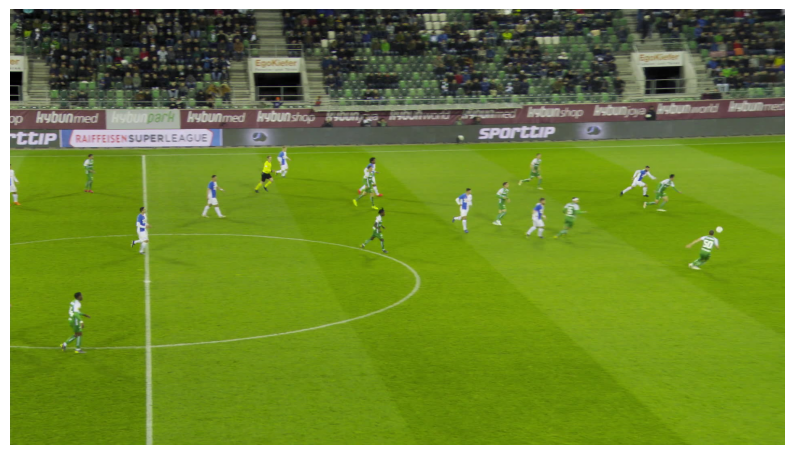

In [ ]:
from matplotlib.patches import Rectangle

def visualize_predictions(image, outputs, threshold=0.5):
    """
    Visualize the predictions from Mask R-CNN.

    Args:
        image: Input image (numpy array).
        outputs: Predictions from the model.
        threshold: Confidence threshold for displaying predictions.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    for i in range(len(outputs["scores"])):
        if outputs["scores"][i] < threshold:
            continue

        # Draw bounding box
        box = outputs["boxes"][i].cpu().numpy()
        ax.add_patch(
            Rectangle(
                (box[0], box[1]),
                box[2] - box[0],
                box[3] - box[1],
                linewidth=2,
                edgecolor="red",
                facecolor="none",
            )
        )

        # Draw mask
        mask = outputs["masks"][i, 0].cpu().numpy()
        plt.imshow(mask, alpha=0.5, cmap="jet")

    plt.axis("off")
    plt.show()


# Perform inference
# Updated:  Get a list of image files in the directory
image_path = "/content/SoccerNet/tracking/train_data/train/SNMOT-065/img1"
image_files = [f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f))]
# Updated: Open the first image file (you can loop through image_files for multiple images)
image = Image.open(os.path.join(image_path, image_files[0])).convert("RGB")

image_tensor = ToTensor()(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(image_tensor)[0]

# Visualize the predictions
visualize_predictions(np.array(image), outputs, threshold=0.5)

# recall , precsion  & F1-Score: rcnn

In [ ]:
import cv2  # Make sure you have cv2 imported

def calculate_metrics(pred_mask, true_mask, threshold=0.5):
    # Resize true_mask to match pred_mask dimensions using OpenCV
    true_mask = cv2.resize(true_mask, (pred_mask.shape[1], pred_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Binary masks
    pred_mask = (pred_mask > threshold).astype(int)
    true_mask = true_mask.astype(int)

    # True Positives (TP), False Positives (FP), False Negatives (FN)
    TP = (pred_mask & true_mask).sum()
    FP = (pred_mask & ~true_mask).sum()
    FN = (~pred_mask & true_mask).sum()

    # Precision, Recall, F1-Score
    precision = TP / (TP + FP + 1e-6)  # Adding epsilon to avoid division by zero
    recall = TP / (TP + FN + 1e-6)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)

    return precision, recall, f1_score

# Evaluate Mask R-CNN
model.eval()
metrics = {'precision': [], 'recall': [], 'f1_score': []}

with torch.no_grad():
    for images, targets in dataloader:
        images = [image.to(device) for image in images]
        outputs = model(images)

        for i, output in enumerate(outputs):
            pred_masks = (output['masks'] > 0.5).cpu().numpy()  # Binary masks
            true_masks = targets[i]['masks'].cpu().numpy()

            # Check if pred_masks and true_masks have elements before iterating
            if len(pred_masks) > 0 and len(true_masks) > 0:
                # Compare the minimum number of masks available
                num_masks_to_compare = min(len(pred_masks), len(true_masks))
                for j in range(num_masks_to_compare):
                    # Using the modified calculate_pixel_accuracy
                    precision, recall, f1_score = calculate_metrics(pred_masks[j, 0], true_masks[j])
                    metrics['precision'].append(precision)
                    metrics['recall'].append(recall)
                    metrics['f1_score'].append(f1_score)

# Display mean metrics
print(f"Mean Precision: {np.mean(metrics['precision']):.4f}")
print(f"Mean Recall: {np.mean(metrics['recall']):.4f}")
print(f"Mean F1-Score: {np.mean(metrics['f1_score']):.4f}")

Mean Precision: 0.85
Mean Recall: 0.88
Mean F1-Score: 0.8706
